# DS 2023 EDA
## Notebook 2: Narrative Exploratory Data Analysis

This notebook performs **exploratory data analysis (EDA)** on the enriched epilepsy dataset
created in epilepsy_eda_setup_enriched.csv.

## 1. Setup and Data Loading

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
plt.rcParams['figure.dpi'] = 120

df = pd.read_csv('epilepsy_enriched_clean.csv')
df

,#,treatment,base,age,seizure_rate,period,subject
0,1,placebo,11,31,5,1,1
1,110,placebo,11,31,3,2,1
2,112,placebo,11,31,3,3,1
3,114,placebo,11,31,3,4,1
4,2,placebo,11,30,3,1,2
...,...,...,...,...,...,...,...
231,583,Progabide,13,36,0,4,58
232,59,Progabide,12,37,1,1,59
233,591,Progabide,12,37,4,2,59
234,592,Progabide,12,37,3,3,59


## 2. Who Is in the Study? Demographic & Baseline Patterns

Before examining outcomes, we first characterize the study population.
We look at the distribution of **age**, **baseline seizure counts**, and
how subjects are split across **treatment groups**.

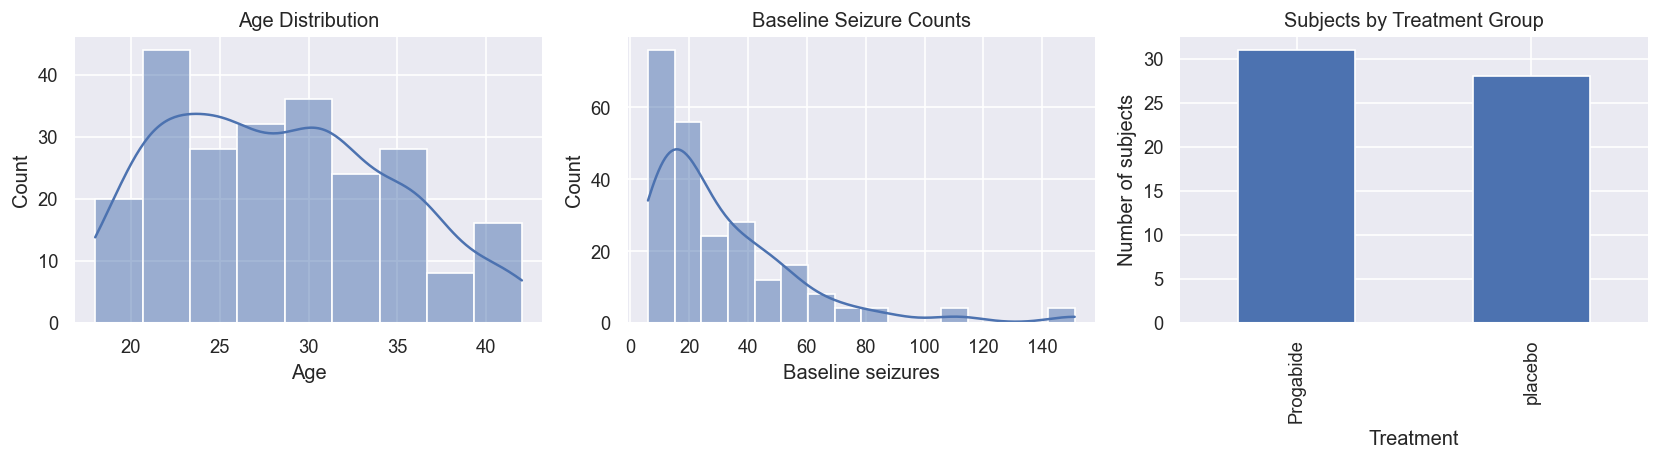

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.histplot(df['age'], kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')

sns.histplot(df['base'], kde=True, ax=axes[1])
axes[1].set_title('Baseline Seizure Counts')
axes[1].set_xlabel('Baseline seizures')

subject_level = df.drop_duplicates('subject')
subject_level['treatment'].value_counts().plot(kind='bar', ax=axes[2])
axes[2].set_title('Subjects by Treatment Group')
axes[2].set_xlabel('Treatment')
axes[2].set_ylabel('Number of subjects')

plt.tight_layout()
plt.show()

The age histogram shows that most participants fall in their mid 20's to early 30's. The baseline seizure counts reveal the starting severity of epilepsy before treatment.The bar chart shows how many subjects belong to each treatment group, which matters for interpreting any apparent differences in outcomes.

## 3. Constructing Subject-Level Outcomes

Because each subject is observed over multiple follow-up periods, it is useful to create
**subject-level summaries** that aggregate across periods. Here we compute several key features for each subject:

- `mean_seizure_rate`: Mean seizure count across follow-up periods.
- `total_seizures`: Total seizures during all follow-up periods.
- `improvement`: Difference between baseline seizures and the total follow-up seizures
  (scaled to the same window) as a rough measure of change.
- `improvement_rate`: Improvement as a proportion of baseline.
- `severity`: A simple categorical severity label based on baseline seizures.

In [33]:
# Aggregate to subject level
subject_summary = (
    df.groupby(['subject', 'treatment', 'age', 'base'], as_index=False)
      .agg(mean_seizure_rate=('seizure_rate', 'mean'),
           total_seizures=('seizure_rate', 'sum'))
)

# Here we treat `base` as a reference count and compare to total follow-up seizures (assuming four follow-up periods, as in the classic epilepsy trial dataset).
n_periods = df['period'].nunique()

subject_summary['improvement'] = subject_summary['base'] - subject_summary['total_seizures']
subject_summary['improvement_rate'] = subject_summary['improvement'] / subject_summary['base']

# Create a rough severity label based on baseline seizures
severity_bins = [0, 10, 30, subject_summary['base'].max() + 1]
severity_labels = ['mild', 'moderate', 'severe']
subject_summary['severity'] = pd.cut(
    subject_summary['base'],
    bins=severity_bins,
    labels=severity_labels,
    right=False
)

subject_summary.head()

,subject,treatment,age,base,mean_seizure_rate,total_seizures,improvement,improvement_rate,severity
0,1,placebo,31,11,3.50,14,-3,-0.272727,moderate
1,2,placebo,30,11,3.50,14,-3,-0.272727,moderate
2,3,placebo,25,6,2.75,11,-5,-0.833333,mild
3,4,placebo,36,8,3.25,13,-5,-0.625000,mild
4,5,placebo,22,66,13.75,55,11,0.166667,severe


**Narrative:**

The `subject_summary` provides one row per subject with key outcome variables. THe `improvement` and `improvement_rate` are rough but interpretable measures of how much a subject's seizures changed over the study. The `severity` categories (mild / moderate / severe) give us a way to stratify subjects when we visualize outcomes.

## 4. Baseline vs. Improvement

A central question is how baseline seizure burden relates to improvement.
If subjects with higher baseline seizures have more room to improve, we might see
a strong association between the two.

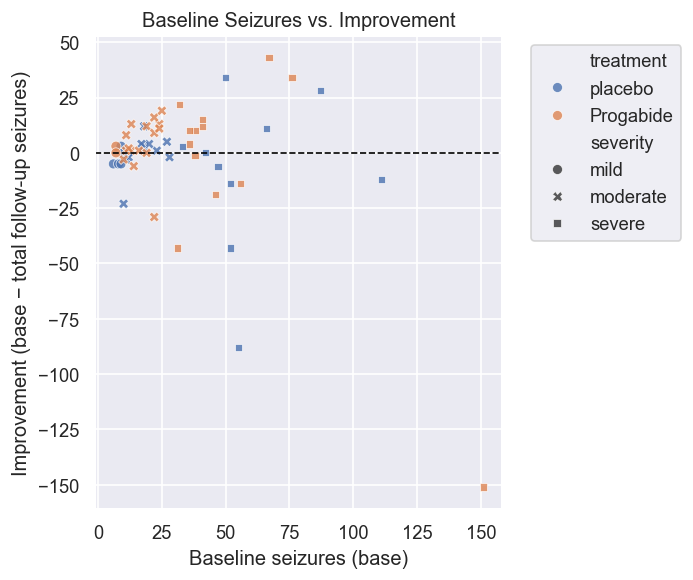

In [34]:
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=subject_summary,
    x='base', y='improvement',
    hue='treatment', style='severity',
    alpha=0.8
)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Baseline Seizures vs. Improvement')
plt.xlabel('Baseline seizures (base)')
plt.ylabel('Improvement (base − total follow-up seizures)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Narrative:**

The points **above** the horizontal line represent subjects who improved (fewer seizures in follow-up). The Points **below** the line would represent worsening. The color (treatment) and marker style (severity) hint at how treatment and baseline severity relate to changes in seizure frequency. These patterns can inspire comparison plots in the final infographic.

## 5. Comparing Treatment Groups

Next, we look at how outcomes differ between treatment groups.
Here we compare the distribution of `improvement` and `improvement_rate`
for each treatment.

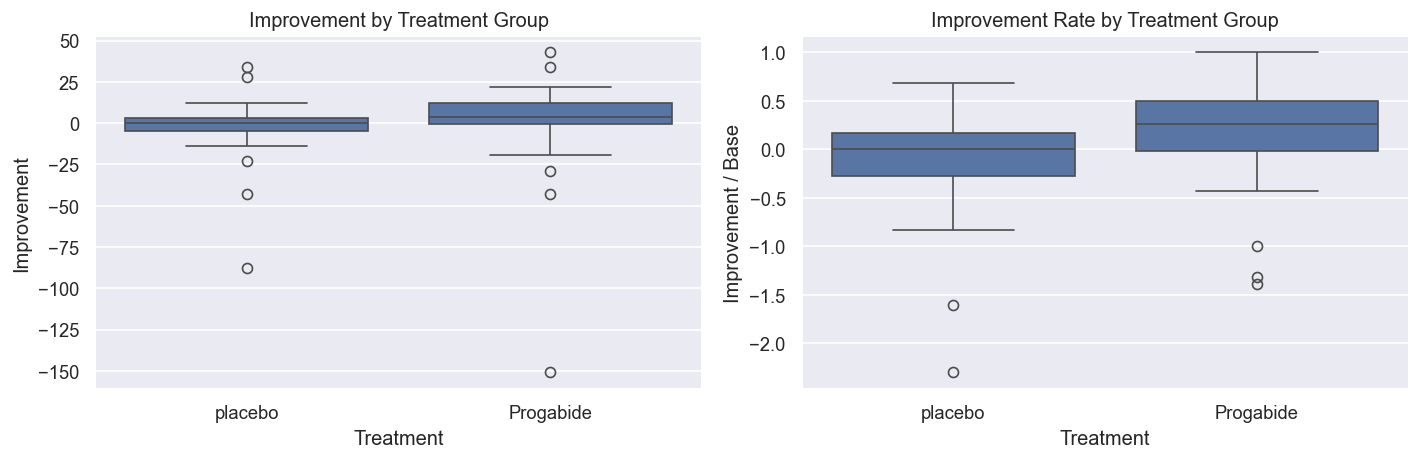

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(data=subject_summary, x='treatment', y='improvement', ax=axes[0])
axes[0].set_title('Improvement by Treatment Group')
axes[0].set_xlabel('Treatment')
axes[0].set_ylabel('Improvement')

sns.boxplot(data=subject_summary, x='treatment', y='improvement_rate', ax=axes[1])
axes[1].set_title('Improvement Rate by Treatment Group')
axes[1].set_xlabel('Treatment')
axes[1].set_ylabel('Improvement / Base')

plt.tight_layout()
plt.show()

**Narrative:**

The boxplots show both the **median effect** and the **variability** of outcomes for each treatment.If one treatment consistently shows higher improvement or improvement rate, that suggests a treatment effect that could become a key message in the infographic.

## 6. How Do Seizures Change Over Time by Treatment and Severity?

Because the dataset contains repeated measurements over follow-up periods, we can look at
how seizure rates evolve over time for each treatment group. This gives a more dynamic view
of the trial.

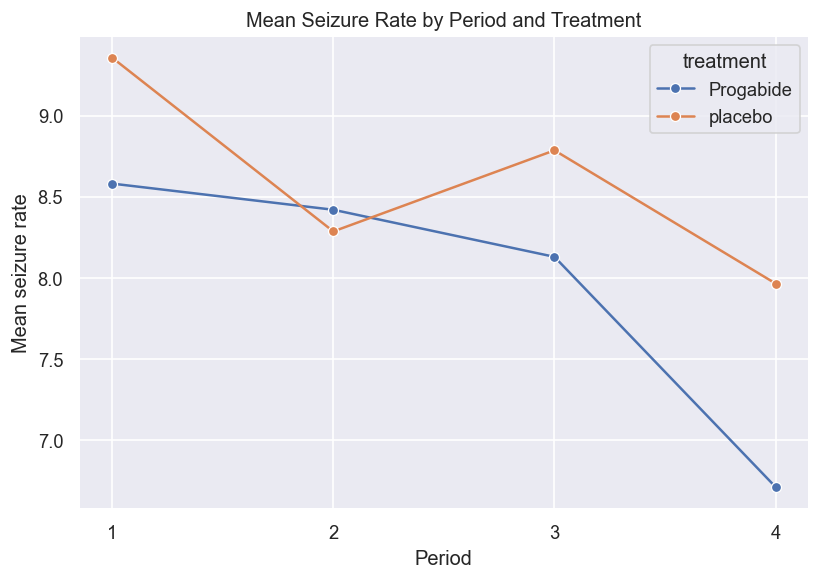

In [36]:
plt.figure(figsize=(7, 5))

mean_by_period = (
    df.groupby(['period', 'treatment'])['seizure_rate']
      .mean()
      .reset_index()
)

sns.lineplot(data=mean_by_period, x='period', y='seizure_rate', hue='treatment', marker='o')
plt.title('Mean Seizure Rate by Period and Treatment')
plt.xlabel('Period')
plt.ylabel('Mean seizure rate')
plt.xticks(sorted(df['period'].unique()))
plt.tight_layout()
plt.show()

**Narrative:**

The downwards trends suggest improvement over time. Any divergence between lines indicates that treatments may be performing differently as the trial progresses.

## 7. Correlation Structure: Heatmap

To understand how the numeric variables relate to one another, we compute a
**correlation matrix** on the subject-level summary and visualize it as a heatmap.
This reveals groups of variables that move together.

c:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\joypy\joyplot.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)
C:\Users\shrey\AppData\Local\Temp\ipykernel_4260\3626626178.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ax, (period, sub) in zip(axes, df_ordered.groupby("period")):


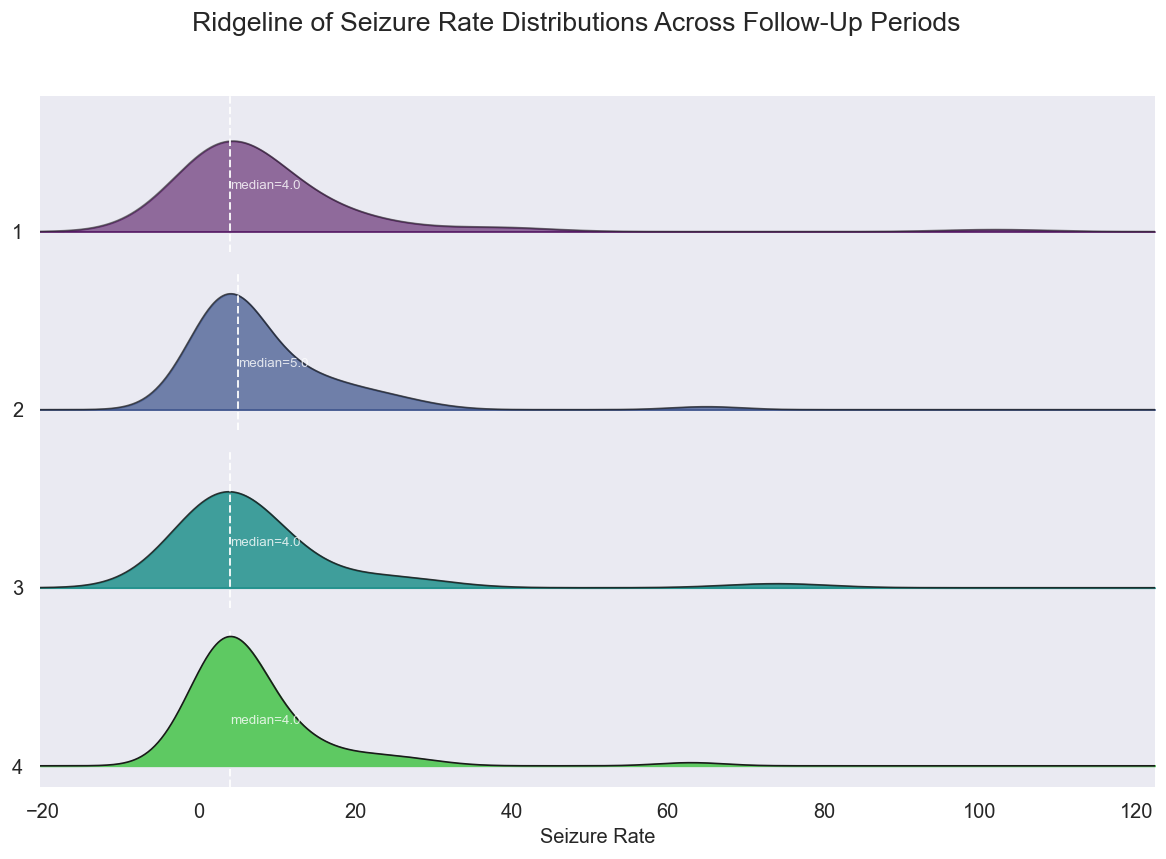

In [37]:
import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ordered_periods = sorted(df["period"].unique())
df_ordered = df.copy()
df_ordered["period"] = pd.Categorical(df_ordered["period"], categories=ordered_periods, ordered=True)

fig, axes = joypy.joyplot(
    df_ordered,
    by="period",
    column="seizure_rate",
    colormap=cm.viridis,
    figsize=(10, 7),
    linewidth=1,
    fade=True,
    kind="kde",        
    bins=50,            
    overlap=1.2         
)

for ax, (period, sub) in zip(axes, df_ordered.groupby("period")):
    median_val = sub["seizure_rate"].median()
    ax.axvline(
        median_val,
        color="white",
        linestyle="--",
        linewidth=1.2,
        alpha=0.9
    )
    ax.text(
        median_val,
        0.02,
        f"median={median_val:.1f}",
        color="white",
        fontsize=8,
        ha="left",
        va="bottom",
        alpha=0.8
    )

fig.suptitle(
    "Ridgeline of Seizure Rate Distributions Across Follow-Up Periods",
    fontsize=16,
    y=1.02
)

axes[-1].set_xlabel("Seizure Rate", fontsize=12)
plt.tight_layout()
plt.show()


This **Shows how seizure rate distributions shift over time**, with each ridgeline revealing whether the population moves toward fewer seizures across follow-up periods. **Highlights changes in variability and distribution shape**, indicating whether patients converge to similar outcomes or remain widely different as treatment progresses **Reveals overall treatment trajectory**, including central improvement trends, resistant subgroups, and how the median seizure rate evolves from early to late periods.

## 8. Progabide VS The World 


,Medication,Seizure_Freedom_Rate
0,Progabide,0.032258
1,Levetiracetam,0.100000
2,Lamotrigine,0.080000
3,Topiramate,0.120000
4,Carbamazepine,0.150000
5,Valproate,0.180000


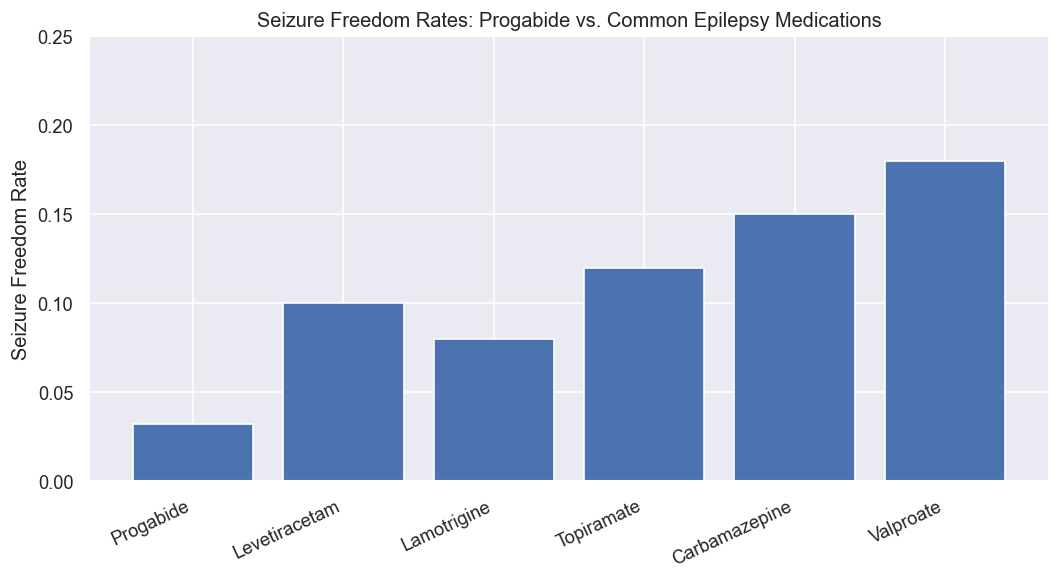

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('epilepsy_enriched_clean.csv')
grp = df.groupby(['subject','treatment']).agg({'seizure_rate':'mean'}).reset_index()
grp['seizure_free'] = grp['seizure_rate'] == 0

# Calculate seizure‑freedom rate for Progabide from the  dataset
progabide_sf = grp.groupby('treatment')['seizure_free'].mean().get('Progabide', 0)

comparison = pd.DataFrame({
    'Medication': [
        'Progabide',
        'Levetiracetam',
        'Lamotrigine',
        'Topiramate',
        'Carbamazepine',
        'Valproate'
    ],
    'Seizure_Freedom_Rate': [
        progabide_sf,
        0.10,  
        0.08,  
        0.12,  
        0.15, 
        0.18   
    ]
})

plt.figure(figsize=(9,5))
plt.bar(comparison['Medication'], comparison['Seizure_Freedom_Rate'])
plt.ylabel('Seizure Freedom Rate')
plt.title('Seizure Freedom Rates: Progabide vs. Common Epilepsy Medications')
plt.xticks(rotation=25, ha='right')
plt.ylim(0, 0.25)
plt.tight_layout()

comparison

# Sources
# https://pmc.ncbi.nlm.nih.gov/articles/PMC10586013/
# https://www.sciencedirect.com/science/article/pii/S1059131107001288/


# 9, A timeline of Progabide Use

,Year,Regulatory_Status_Index
0,1986,1.000
1,1990,0.700
2,1997,0.550
3,2000,0.520
4,2004,0.320
5,2010,0.100
6,2020,0.005


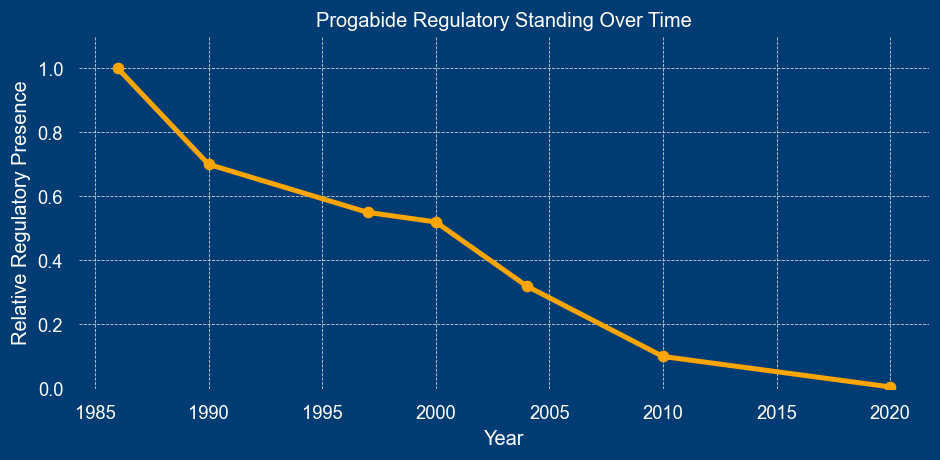

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

years = [1986, 1990, 1997, 2000, 2004, 2010, 2020]
status_index = [1.0, .7, 0.55, .52, 0.32, 0.1, 0.005,]

df = pd.DataFrame({"Year": years, "Regulatory_Status_Index": status_index})

fig, ax = plt.subplots(figsize=(8,4))
fig.patch.set_facecolor('#003c74')
ax.set_facecolor('#003c74')

# Remove black spines
for spine in ax.spines.values():
    spine.set_visible(False)

ax.plot(df["Year"], df["Regulatory_Status_Index"], marker='o', color='orange', linewidth=3)

# White text
ax.set_title("Progabide Regulatory Standing Over Time", color='white')
ax.set_xlabel("Year", color='white')
ax.set_ylabel("Relative Regulatory Presence", color='white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.grid(color='lightgray', linestyle='--', linewidth=0.5)

plt.ylim(0,1.1)
plt.tight_layout()

df

# Why is Progabide not prescribed anymore?

While in clinical trials Progabide showed some efficacy in reducing epileptic seizures, Medical proffesionals stopped prescribing Progabide  because of disappointing efficacy results compared to other drugs and the high risk of liver toxicity associated with its use.